# Reverse inference - Example without using ontologies

In [2]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

We will use the FMA ontology to obtain regions of the brain included within the `Temporal lobe`. We will obtain all the entities that make up the `Temporal Lobe` and then we will convert them into regions using the information provided by the Destrieux atlas. This will allow us to perform spatial operations on these regions, allowing us to obtain those NeuroSynth regions associated with the term `auditory` that overlap our results.



In [2]:
nl = fe.NeurolangDL()
datasets_helper.load_reverse_inference_dataset_deterministic(nl)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()


In [3]:
@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

### Testing julich atlas

In [4]:
with nl.scope as e:
    
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area 44 (IFG)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [5]:
def create_region(x, y, z, img):
    voxels = nib.affines.apply_affine(
        np.linalg.inv(img.affine), np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, img.affine, image_dim=img.shape)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


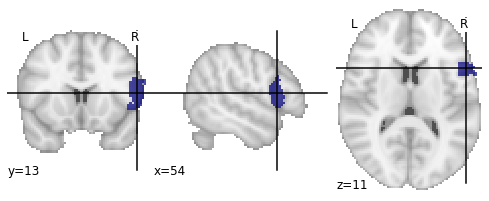

In [7]:
from neurolang.regions import region_union
import nibabel as nib
from nilearn import image

results = nl_results['julich_voxels'].unwrapped_iter()

nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table

regions = []
vox_prob = []

atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'
img_r = image.load_img(atlas_r_filename)
julich_to_ns_mni = image.resample_to_img(
    img_r, it.masker.volume, interpolation="nearest"
)

for id_, x, y, z in results:
    r_overlay = create_region(x, y, z, julich_to_ns_mni)
    vox_prob.append((r_overlay.voxels, 1))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=regions.affine
)
for v, p in vox_prob:
    prob_img.dataobj[tuple(v.T)] = p

#plotting.plot_stat_map(
#    prob_img, 
    #title='Tag "auditory" (Neurolang)', 
    #bg_img='/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/resources/MNI152_T1_2mm_brain.nii.gz',
#    cmap='PuBuGn',
#    display_mode='x',
#    cut_coords=np.linspace(-63, 63, 4),
#)


plotting.plot_roi(prob_img)


### Example

In [8]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area TE 3 (STG)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [10]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');


In [11]:
with nl.scope as e:
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [12]:
c = nl_results['e_term_given_aud_act']._container.copy()

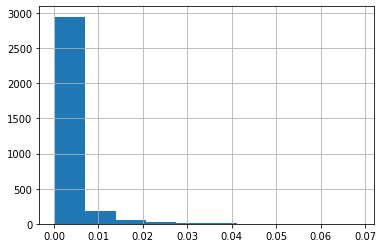

In [13]:
c[1].hist();

In [14]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
2941,temporal,0.068645
1692,magnetic,0.059713
2504,resonance,0.059262
1693,magnetic resonance,0.059026
1217,functional magnetic,0.056872
3082,using,0.054263
2921,task,0.050347
1290,gyrus,0.049727
1192,frontal,0.048264
2876,superior,0.047945


# Reverse inference - Example using ontologies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS, RDF
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

nl = fe.probabilistic_frontend.ProbabilisticFrontend()

datasets_helper.load_reverse_inference_dataset_deterministic(nl)

paths = 'neurolang_data/ontologies/cogat.xrdf'
nl.load_ontology(paths)


@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0].lower()



/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

In [2]:
part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))

In [3]:
triples = nl.symbol_table[nl.get_ontology_triples_symbol().name]
a = triples.value.as_numpy_array()
t = [('Auditory', str(RDF.type), 'http://www.cognitiveatlas.org/ontology/cogat.owl#CAO_00148')]

t = np.concatenate((a, t))
nl.add_extensional_predicate_from_tuples(t, name=nl.get_ontology_triples_symbol().name)

In [4]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area TE 3 (STG)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [5]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');

In [6]:
with nl.scope as e:
    e.pre_part[e.x, e.y] = part_of[e.x, e.y]

    e.ontology_terms[e.term] = (
        e.pre_part["Auditory", e.y] & subclass_of[e.z, e.y] & label(e.z, e.n) &
        (e.term == nl.symbols.first_word(e.n))
    )
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [7]:
nl_results['ontology_terms']

                  0
0         gustation
1       audiovisual
2          auditory
3         synchrony
4         detection
5            visual
6           animacy
7            visual
8            object
9    discrimination
10  somatosensation
11        olfactory
12            depth

In [8]:
nl_results['e_term_given_aud_act']

                   0         1
0                001  0.000496
1                 01  0.000996
2                 05  0.001971
3                 10  0.005979
4                100  0.000996
...              ...       ...
3223     young older  0.000382
3224         younger  0.002371
3225  younger adults  0.000881
3226           youth  0.000377
3227            zone  0.000749

[3228 rows x 2 columns]

In [13]:
t = nl_results['ontology_terms'].as_numpy_array()
f = [tuple(term) for term in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='ontology_terms');

t = nl_results['e_term_given_aud_act'].as_numpy_array()
f = [(term, p) for term, p in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='reverse_inference');

In [30]:
lt = set()
onto = nl_results['ontology_terms'].as_numpy_array()
for term, p in nl_results['reverse_inference'].as_numpy_array():
    if term in onto:
        print(term)
    lt.add(term)

audiovisual
auditory
depth
detection
discrimination
object
olfactory
visual


In [28]:
nl_results['ontology_terms']

                  0
0         gustation
1       audiovisual
2          auditory
3         synchrony
4         detection
5            visual
6           animacy
7            visual
8            object
9    discrimination
10  somatosensation
11        olfactory
12            depth

In [16]:
with nl.scope as e:
    e.filtered_terms[e.term, e.p] = (
        e.reverse_inference[e.term, e.p] &
        e.ontology_terms[e.term]
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [31]:
c = nl_results['filtered_terms']._container.copy()
c

,0,1
0,audiovisual,0.003679
1,auditory,0.040106
2,depth,0.000968
3,detection,0.006216
4,discrimination,0.004777
5,object,0.006545
6,olfactory,0.000287
7,visual,0.029216
8,visual,0.029216


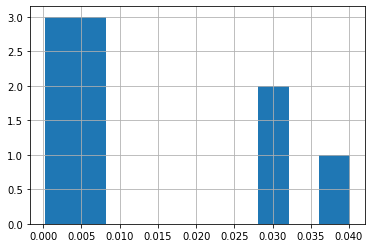

In [18]:
c[1].hist();

In [19]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
1,auditory,0.040106
